In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from dateutil import rrule
import datetime
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
import shutil
import datetime as dt
from IPython.display import display, clear_output
import geopy.distance as distance
import pickle
%matplotlib inline

In [2]:
def log_2_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return np.round(2**x,3)
formatter = plt.FuncFormatter(log_2_product)

## Part 1: Analysis of Main Data (Before Splitting to Trips)

In [3]:
# import data
df_tripMain = pd.read_csv('/scratch/skp454/Trajectory/TaxiDataSet/data/20190627_TaxiTripMainData.csv')
del df_tripMain['Unnamed: 0']
df_tripMain.head()

,TaxiID,BaseDateTime,LON,LAT,TimeDiff,IdDiff,Dist,Speed,Stationary,trip_id
0,1,2008-02-02 15:36:08,116.51172,39.92123,0.0,False,0.000000,0.000000,True,1
1,1,2008-02-02 15:46:08,116.51135,39.93883,600.0,True,1.954442,11.726651,False,1
2,1,2008-02-02 15:56:08,116.51627,39.91034,600.0,True,3.191175,19.147047,False,1
3,1,2008-02-02 16:06:08,116.47186,39.91248,600.0,True,3.804664,22.827986,False,1
4,1,2008-02-02 16:16:08,116.47217,39.92498,600.0,True,1.388166,8.328999,False,1


### Part 1.0: Trajectory and Data Points

Here we check the number of vessels/trajectories in our dataset, and the distribution of the number of data points corresponding to each trajectories.

In [4]:
# Number of trajectories and data points
print('Total Number of Trajectories:', len(df_tripMain.TaxiID.unique()))
print('Total Number of Data Points:', len(df_tripMain)/1000000, "Millions")

Total Number of Trajectories: 10292
Total Number of Data Points: 16.271472 Millions


**We have 10292 traj and 16.27million data points**

Roughly we have 1500 points per trajectory

In [5]:
# Percentile Distribution of Data Points per Trajectory
print("Data Points per Trajectory")
pd.DataFrame(df_tripMain.TaxiID.value_counts().quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Data Points per Trajectory


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
TaxiID,1.0,74.55,354.1,614.2,804.3,959.0,1263.5,1514.6,1617.0,1669.0,1866.9,2938.45,148069.0


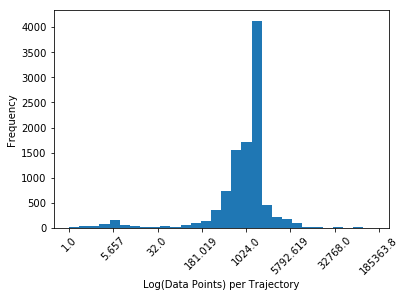

In [6]:
# Log distribution of Data Points per trajectory 
ax = plt.subplot()
ax.hist(np.log2(df_tripMain.TaxiID.value_counts()), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Log(Data Points) per Trajectory")
plt.ylabel("Frequency")
plt.show()

**Bimodal in Data Points per Trajectory**

1. Few trajectories are centered around 8 datapoints/trajectory.
2. Modt of the trajectories have around 1000 datapoints/traj.

### Part 1.1 : Time Interval (Sec)

Here we check the distribution of time interval between 2 consecutive data points corresponding to same trajectory in our dataset.

In [7]:
# Percentile Distribution of Time Interval
print("Time in Seconds")
pd.DataFrame(df_tripMain.TimeDiff.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Time in Seconds


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
TimeDiff,0.0,3.0,5.0,7.0,39.0,106.0,210.0,300.0,300.0,300.0,302.0,600.0,516034.0


**95 % Data points have time difference less than 600 Seconds or 10 minutes**

1. 20% data has less than 10seconds difference.
2. Almost 40% data have time difference of exactly 5 minutes.

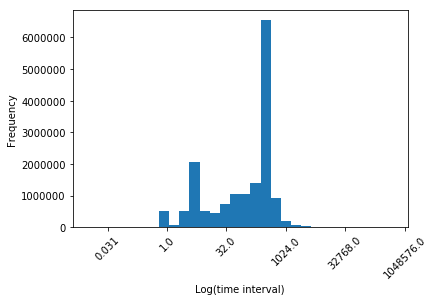

In [8]:
# Histogram Distribution of Log(TimeInterval)
ax = plt.subplot()
ax.hist(np.log2(df_tripMain.TimeDiff+ 0.01), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Log(time interval)")
plt.ylabel("Frequency")
plt.show()

### Part 1.2: Distance (Kms)

Here we check the distribution of Distance(kms) between 2 consecutive data points corresponding to the same trajectory in our dataset.

In [9]:
# Percentile Distribution of Distance
print("Distance in Kms")
pd.DataFrame(df_tripMain.Dist.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Distance in Kms


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Dist,0.0,0.0,0.0,0.00111,0.004523,0.014533,0.047644,0.200422,0.564407,1.107751,2.055924,3.1983,895.930445


**Uniform Distribution in Distance between Consecutive points**
1. 20% data points have 0 or insignificant distance distribution between them.
2. 80% data points have distance difference of less than 1 km between them(major peak).

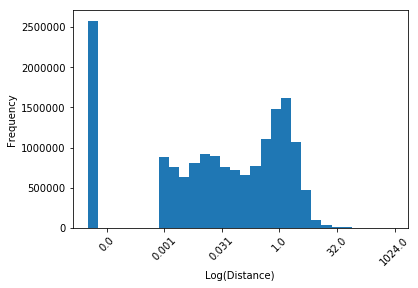

In [10]:
# Histogram Distribution of Log(Distance)
ax = plt.subplot()
ax.hist(np.log2(df_tripMain.Dist+ 0.00001), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Log(Distance)")
plt.ylabel("Frequency")
plt.show()

### Part 1.3: Speed (Km/Hr)

Here we check the distribution of Speed(km/hr) between 2 consecutive data points corresponding to the same trajectory in our dataset.

In [11]:
# Percentile Distribution of Distance
print("Speed in Km/Hr")
pd.DataFrame(df_tripMain.Speed.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Speed in Km/Hr


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Speed,0.0,0.0,0.0,0.016808,0.126763,1.184032,7.340682,13.363221,19.314345,26.861227,39.97198,53.082129,2.451989e+06


**30% Data points have speed lower than 0.12km/hrs**

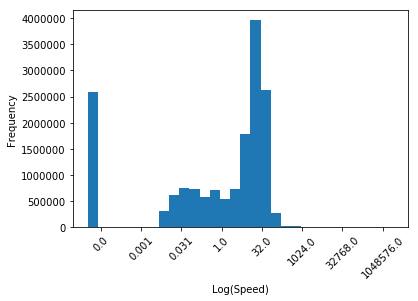

In [12]:
# Histogram Distribution of Log(Distance)
ax = plt.subplot()
ax.hist(np.log2(df_tripMain.Speed+0.00001), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Log(Speed)")
plt.ylabel("Frequency")
plt.show()

**Similar to distance, a major peak at 20km/hr(Average Speed in City Driving conditions)**

## Part2:  Create Trip

In [13]:
# define stationary points (speed<1km/hr)
df_tripMain['Stationary'] = df_tripMain['Speed']<1
df_tripMain['Stationary'] = df_tripMain['Stationary'].astype(int)

# stationary time
df_tripMain['StaTime'] = df_tripMain['TimeDiff'] * df_tripMain['Stationary']

# cumulative stationary time
df_tripMain['StaTime'] = df_tripMain['StaTime'].cumsum()

# non-stationary points
df_tripMain['InvStat'] = ((df_tripMain['Stationary'] == 0) + (df_tripMain['IdDiff'] == 0)).astype(int)

# Id to non stationary points
df_tripMain['InvID'] = df_tripMain['InvStat'].cumsum()

# array to store cumulative stationary time of non stationary points
arr =np.array(df_tripMain[df_tripMain['InvStat']==1]['StaTime'])

# find the cumulative stationary time at last non-stationary point
df_tripMain['nT'] = df_tripMain['InvID'].apply(lambda row: arr[row-1])

# subtract the cumulative stationary time of last non-stationary point from the current point
df_tripMain['StaTime'] = df_tripMain['StaTime'] - df_tripMain['nT']

## Calculate the distribution of max stationarity period
df_tripMain['InvStat'] = list(df_tripMain['InvStat'][1:]) + [0]
arr =np.array(df_tripMain[df_tripMain['InvStat']==1]['StaTime'])
arr = arr[arr>0]

# modify sttaionary flag; if stationary time > 5minutes
df_tripMain['Stationary'] = ((df_tripMain['StaTime'] > 300 ) + (df_tripMain['IdDiff'] == 0)).astype(int)

# drop temp columns
df_tripMain.drop(['trip_id', 'StaTime', 'InvStat', 'InvID', 'nT'], inplace= True, axis=1)

# create trip id
df_tripMain['trip_id'] = df_tripMain['Stationary'].cumsum()

# remove staionarity markers
df_main = df_tripMain[df_tripMain['Stationary'] == False]
df_main['Count'] = 1

# create trip stats
df_trip = pd.DataFrame(df_main.groupby(['trip_id','TaxiID'], as_index=False)['Dist','TimeDiff','Count'].sum())

# create trip speed
df_trip['Speed'] = df_trip['Dist']*3600/df_trip['TimeDiff']
df_trip['Speed'].fillna(0, inplace= True)

# delete df_main
del df_main

/home/skp454/bigdata/bdpy/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/skp454/bigdata/bdpy/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Stationarity Time Distribution

In [15]:
pd.DataFrame(pd.Series(arr).quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
0,1.0,5.0,10.0,25.0,51.0,118.0,300.0,401.0,900.0,2109.0,8998.0,27219.0,532528.0


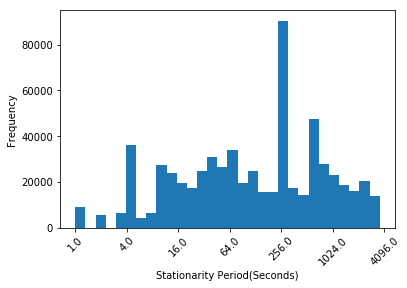

In [19]:
ax = plt.subplot()
ax.hist(np.log2(arr[arr<3600]), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Stationarity Period(Seconds)")
plt.ylabel("Frequency")
plt.show()

In [15]:
# save trip main record
outfile = open('/scratch/skp454/Trajectory/TaxiDataSet/data/20190709_TaxiTripMainData.pkl','wb')
pickle.dump(df_tripMain,outfile)
outfile.close()
del outfile

### Part 2.0: Cleaning trips on records per trip

In [16]:
# Number of trajectories and data points
print('Total Number of Trips:', len(df_trip.trip_id.unique()))

Total Number of Trips: 360553


In [17]:
# Percentile Distribution of length of sequence per trip
print("Data Points per Trip")
pd.DataFrame(df_trip.Count.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Data Points per Trip


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Count,1.0,1.0,2.0,3.0,4.0,6.0,9.0,15.0,23.0,38.0,66.0,104.0,49778.0


**Presence of large number of Erroneous Trips**

**5% of trips have only 1 data points; we will remove them**

In [18]:
# update the trips (count>1)
df_trip = df_trip[df_trip['Count']>1]

# Number of trips
print('Total Number of Trips:', len(df_trip.trip_id.unique()))

Total Number of Trips: 338016


**We lost 22k trips here**

### Part 2.1: Cleaning trips on Distance

In [19]:
# Percentile Distribution of Distance
print("Distance in Kms")
pd.DataFrame(df_trip.Dist.quantile([0,0.05] + list(np.round(np.arange(0.1,0.91,0.1),2)) + [0.95,1.00])).T

Distance in Kms


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Dist,0.0,0.134035,0.315841,1.775496,4.525937,8.998796,15.715876,25.433728,39.077395,59.357323,94.420869,132.309971,18606.912008


**15% Trips have travelled distance less than 1km**

**We remove trips with distance travelled < 1km**

In [20]:
# update the trips (dist>10)
df_trip = df_trip[df_trip['Dist']>1]

# Number of trips
print('Total Number of Trips:', len(df_trip.trip_id.unique()))

Total Number of Trips: 283657


**We loose 54k trips here**

In [21]:
# Percentile Distribution of Distance
print("Speed in Km/Hr")
pd.DataFrame(df_trip.Speed.quantile(list(np.round(np.arange(0.97,1.00001,0.003),3)))).T

Speed in Km/Hr


,0.97,0.973,0.976,0.979,0.982,0.985,0.988,0.991,0.994,0.997,1.0
Speed,78.713021,92.866513,110.677027,133.155182,163.797831,205.750136,258.408476,332.889062,462.754,743.484477,269464.025335


**Speed beyond 150km/hr are unreasonable**

**We remove trips with average speed beyond 150km/hr**

In [22]:
# update the trips (speed>150)
df_trip = df_trip[df_trip['Speed']<150]

# Number of trips
print('Total Number of Trips:', len(df_trip.trip_id.unique()))

Total Number of Trips: 278215


**We loose around 5k trips here**

In [23]:
## Save Trips
outfile = open('/scratch/skp454/Trajectory/TaxiDataSet/data/20190709_TaxiTripStatsData.pkl','wb')
pickle.dump(df_trip,outfile)
outfile.close()
del outfile

## Part 2: Analysis of Trip Data

Based on the information obtained in Part 1.4, we split the trajectories into trips wherever the speed is lower than 0.03km/hr.
The segmentation was done in a separate program and the resultant trips were saved.

In this Part of the notebook, we will analyze the statistics of trips on Trip Sequence Length, Total Trip Distance, Total Trip Time Interval, Trip Average Speed, and Trip Overall Displacement.

### Part 2.0: Trip Sequence length

The number of data points in each trip determines its sequence length.

In [24]:
# Number of trajectories and data points
print('Total Number of Trips:', len(df_trip.trip_id.unique()))

Total Number of Trips: 278215


In [25]:
# Percentile Distribution of length of sequence per trip
print("Data Points per Trip")
pd.DataFrame(df_trip.Count.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Data Points per Trip


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Count,2.0,3.0,3.0,5.0,7.0,10.0,15.0,21.0,31.0,46.0,76.0,116.0,17962.0


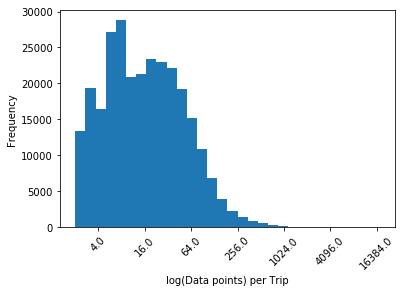

In [27]:
# Log distribution of Data Points per trajectory 

ax = plt.subplot()
ax.hist(np.log2(df_trip.Count), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("log(Data points) per Trip")
plt.ylabel("Frequency")
plt.show()

### Part 2.1: Trip and Trajectories

Originally we had 10k Vessels/Trajectories.
1. In this section we will see total number of vessels left after removing trips of length less than 1 data point.
2. Number of trips per trajectory.

In [28]:
# Number of trajectories and data points
print('Total Number of Trajectories:', len(df_trip.TaxiID.unique()))
print('Total Number of Data Points:', sum(df_trip.Count)/1000000, "Millions")

Total Number of Trajectories: 9981
Total Number of Data Points: 10.522328 Millions


**We have lost approximately 100 taxi and about 6 Million original data points**

In [29]:
# Percentile Distribution of Trips per Trajectory
print("Trips per Trajectory")
pd.DataFrame(df_trip.TaxiID.value_counts().quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Trips per Trajectory


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
TaxiID,1.0,9.0,14.0,19.0,22.0,25.0,27.0,30.0,33.0,37.0,43.0,48.0,164.0


**The median number of trip we have got per taxi is about 27**

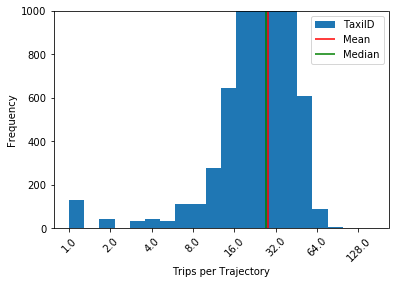

In [30]:
# Log distribution of Data Points per trajectory 
ax = plt.subplot()
ax.hist(np.log2(df_trip.TaxiID.value_counts()), bins =20)
ax.xaxis.set_major_formatter(formatter)
plt.vlines(np.log2(np.mean(df_trip.TaxiID.value_counts())),0,1000, label = 'Mean', color='red')
plt.vlines(np.log2(np.median(df_trip.TaxiID.value_counts())),0,1000, label = 'Median', color='green')
plt.ylim(0,1000)
plt.xticks(rotation=45)
plt.xlabel("Trips per Trajectory")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Part2.2: Trip Time Intervals(Sec)

In [33]:
# Percentile Distribution of Time Interval
print("Time in Minutes")
pd.DataFrame((df_trip.TimeDiff/60).quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Time in Minutes


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
TimeDiff,0.45,10.066667,15.0,22.3,32.25,45.766667,65.783333,95.0,136.1,200.6,307.466667,421.921667,6610.8


**The median length of trip in time is around 65 Minutes**

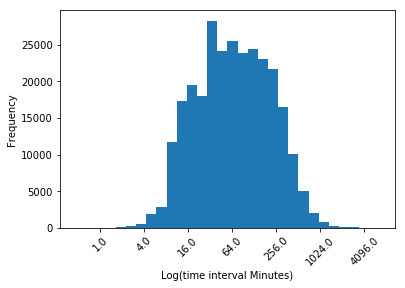

In [36]:
# Histogram Distribution of Log(TimeInterval)
ax = plt.subplot()
ax.hist(np.log2(df_trip.TimeDiff/60+ 0.01), bins =30)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.xlabel("Log(time interval Minutes)")
plt.ylabel("Frequency")
plt.show()

**There are 2 peaks in the distribution signalling a lot of trips are sub segments of other trips.**
1. The peak at around log value 7 corresponds to time difference of ~20minutes average length of trip.

2. The peak around log value 2 corresponds to time difference of ~11seconds signalling they are subsegments of other trips.

3. In city traffic condition, vehicles frequently accelerate and deacclerate thus, resulting in drop of speed below given threshold and development of these subsection of trips.

### Part 2.3: Trip Distance (Kms)

In [37]:
# Percentile Distribution of Distance
print("Distance in Kms")
pd.DataFrame(df_trip.Dist.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

Distance in Kms


,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0
Dist,1.000097,1.824054,2.786065,5.479896,9.429567,14.952359,22.481722,32.556245,46.416669,66.208523,100.355982,136.295838,2048.845021


**40% trips travelled have distance less than 75metres**

**The distance distribution is bimodal reinforcing that a lot of trip are subsections of other trips.**

In [ ]:
# Histogram Distribution of Log(Distance)
plt.hist(np.log(df_trip.Dist+ 0.00001), bins =30)
plt.xlabel("Log(Distance)")
plt.ylabel("Frequency")
plt.show()

### Part 2.4: Trip Average Speed (Km/Hr)

In [ ]:
# Percentile Distribution of Distance
print("Speed in Km/Hr")
pd.DataFrame(df_trip.Speed.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

**50% trips have speed around 1.25km/hrs**

In [ ]:
# Histogram Distribution of Log(Speed)
plt.hist(np.log(df_trip.Speed+0.00001), bins =30)
plt.xlabel("Log(Speed)")
plt.ylabel("Frequency")
plt.show()

### Part 2.5: Trip Displacement (Kms)

In [ ]:
# Percentile Distribution of Distance
print("Displacement in Kms")
pd.DataFrame(df_trip.displacement.quantile([0,0.05] + list(np.round(np.arange(0.1,1,0.1),2)) + [0.95,1.00])).T

**50% trips have displacement less than 26m**

### Part 2.6: Displacement vs Distance of Trips

In [ ]:
plt.plot(df_trip.Dist, df_trip.displacement, '.')
plt.xlabel('Distance(Kms)')
plt.ylabel('Displacement(Kms)')

### Part 2.7: Distance vs Trip Length of Trips

In [ ]:
plt.plot(df_trip.Count,df_trip.Dist, '.')
plt.xlabel('Trip Length')
plt.ylabel('Distance(kms)')

### Part 2.8: Displacement vs Trip Length

In [ ]:
plt.plot(df_trip.Count,df_trip.displacement, '.')
plt.xlabel('Trip Length')
plt.ylabel('Distance(kms)')

### Part 1.4(Important) : % Data Covered by Trip Length for Different Speed Thresholds 

To split trajectory into trips, in the proposed method we are going to use the drop of speed below a given threshold as a flag for stationarity.

Conducting segmentation like this splits the trajectory into a number of segments of varying length and a lot of free points with length 1.

These free points cannot be used further and thus results into loss of original data.

We use different speed to check what % of data get lost in the form of these free data points.

In the following graph we find % Data Covered in Trips with length > Given Trip Length(x-axis).

In [ ]:
df_tripMain.head()

In [ ]:
df_th = pd.DataFrame(columns=['th','data'])
a = 0
plt.figure(figsize=(18, 12))
for th in [0.012,0.016,0.03,0.041,0.085,0.197]:
    # stationarity
    df_tripMain['Stationary'] = df_tripMain['Speed']<th
    # stationarity id
    df_tripMain['trip_id'] = df_tripMain['Stationary'].cumsum()
    df_tripCount1 = pd.DataFrame(df_tripMain.groupby(['trip_id'])['Dist'].sum())
    df_tripCount2 = pd.DataFrame(df_tripMain['trip_id'].value_counts())
    df_tripCount = pd.concat([df_tripCount1, df_tripCount2], axis =1)
    df_tripCount = df_tripCount[df_tripCount['trip_id']>2]
    plt.subplot(2,3,a+1)
    plt.hist(np.log(df_tripCount['Dist']), label = str(th)+'Km/hr', density=True, bins =30 )
    plt.legend()
    plt.xlabel('Log(Trip Distance)')
    plt.ylabel('frequency')
    a = a+1


#plt.title('% Distance distributions of trips')

#print(df_th.T)

In [ ]:
df_th = pd.DataFrame(columns=['th','data'])
a = 0
for th in [0.016,0.03,0.041,0.085,0.197,0.591]:
    # stationarity
    df_tripMain['Stationary'] = df_tripMain['Speed']<th
    # stationarity id
    df_tripMain['trip_id'] = df_tripMain['Stationary'].cumsum()
    df_tripCount = pd.DataFrame(df_tripMain['trip_id'].value_counts())
    df_tripCount = pd.DataFrame(df_tripCount.groupby(['trip_id'])['trip_id'].sum())
    df_tripCount['Data'] = df_tripCount['trip_id'].cumsum()
    df_tripCount['Data'] = df_tripCount['Data']/df_tripCount['trip_id'].sum()
    df_th.loc[a,'th']= th
    df_th.loc[a,'data'] = 1- df_tripCount.iloc[0,1]
    a = a + 1
    plt.plot(np.log(df_tripCount.index), 1- df_tripCount['Data'], label = str(th)+'Km/hr')

plt.legend()
plt.title('% Data Covered in Trips with length > Given Trip Length')
plt.xlabel('Log(Trip Length)')
plt.ylabel('% Data Covered')
print(df_th.T)

In [ ]:
# reverting back the stationarity and trip_id to its original state
df_tripMain['Stationary'] = df_tripMain['Speed']<0.03
df_tripMain['trip_id'] = df_tripMain['Stationary'].cumsum()